In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Importing the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
labels = ['normal', 'abnormal']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [4]:
train = get_training_data('../input/breastcancerlaisonsplit/split/split/train')
test = get_training_data('../input/breastcancerlaisonsplit/split/split/val')
# val = get_training_data('../input/busi-augmented/Augmented/val')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


# Data Visualization & Preprocessing

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

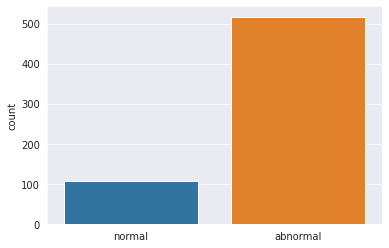

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("normal")
    else:
        l.append("abnormal")
sns.set_style('darkgrid')
sns.countplot(l)        

Text(0.5, 1.0, 'abnormal')

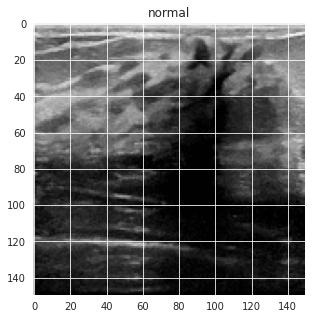

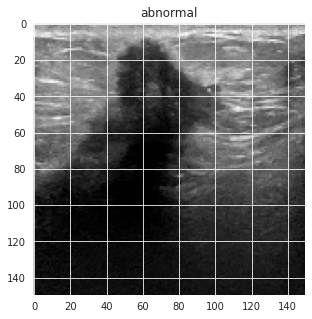

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

# x_val = []
# y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
# for feature, label in val:
#     x_val.append(feature)
#     y_val.append(label)

In [8]:
len(y_test)

156

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [9]:
# Normalize the data
x_train = np.array(x_train) / 255
# x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [10]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

# x_val = x_val.reshape(-1, img_size, img_size, 1)
# y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [11]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

In [12]:
import tensorflow as tf 
print(tf.__version__)

2.6.4


In [13]:
!pip install tensorflow-addons==0.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.8 MB/s eta 0:00:00a 0:00:010m
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.14.0
    Uninstalling tensorflow-addons-0.14.0:
      Successfully uninstalled tensorflow-addons-0.14.0


# Training the Model

In [45]:
import tensorflow as tf
import tensorflow_addons as tfa

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

metrics = ['accuracy', "binary_accuracy", tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TruePositives(),
          tf.keras.metrics.TrueNegatives(), tfa.metrics.F1Score(num_classes = 1)]

model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = metrics)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)       

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint("CNN.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)

callbacks = [learning_rate_reduction, earlystop, checkpoint]

In [46]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 50 , validation_data = datagen.flow(x_test, y_test) ,callbacks = callbacks)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.2935 - accuracy: 0.7388 - binary_accuracy: 0.7388 - auc_1: 0.5721 - precision_1: 0.8290 - recall_1: 0.8627 - true_positives_1: 446.0000 - true_negatives_1: 15.0000 - f1_score: 0.9062

/opt/conda/lib/python3.7/site-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


20/20 [==============================] - 4s 109ms/step - loss: 1.2935 - accuracy: 0.7388 - binary_accuracy: 0.7388 - auc_1: 0.5721 - precision_1: 0.8290 - recall_1: 0.8627 - true_positives_1: 446.0000 - true_negatives_1: 15.0000 - f1_score: 0.9062 - val_loss: 3.6413 - val_accuracy: 0.1667 - val_binary_accuracy: 0.1667 - val_auc_1: 0.4231 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_true_positives_1: 0.0000e+00 - val_true_negatives_1: 26.0000 - val_f1_score: 0.9091

Epoch 00001: val_loss improved from inf to 3.64127, saving model to CNN.h5
Epoch 2/50
20/20 [==============================] - 1s 76ms/step - loss: 0.5371 - accuracy: 0.8205 - binary_accuracy: 0.8205 - auc_1: 0.6068 - precision_1: 0.8303 - recall_1: 0.9845 - true_positives_1: 509.0000 - true_negatives_1: 3.0000 - f1_score: 0.9062 - val_loss: 3.3017 - val_accuracy: 0.1667 - val_binary_accuracy: 0.1667 - val_auc_1: 0.5195 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_true_positives_1: 0.0000e

In [47]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

5/5 [==============================] - 1s 12ms/step - loss: 0.4916 - accuracy: 0.8333 - binary_accuracy: 0.8333 - auc_1: 0.5102 - precision_1: 0.8333 - recall_1: 1.0000 - true_positives_1: 130.0000 - true_negatives_1: 0.0000e+00 - f1_score: 0.9091
Loss of the model is -  0.4916110336780548
5/5 [==============================] - 0s 15ms/step - loss: 0.4916 - accuracy: 0.8333 - binary_accuracy: 0.8333 - auc_1: 0.5102 - precision_1: 0.8333 - recall_1: 1.0000 - true_positives_1: 130.0000 - true_negatives_1: 0.0000e+00 - f1_score: 0.9091
Accuracy of the model is -  83.33333134651184 %


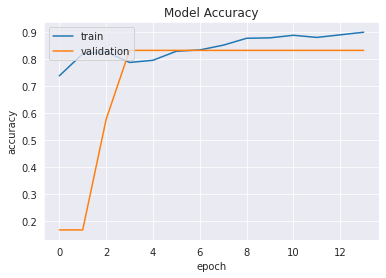

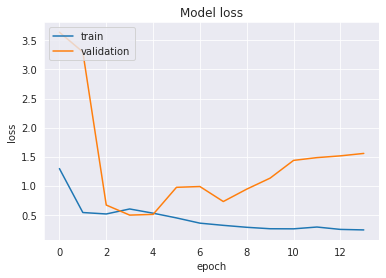

In [48]:
#plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

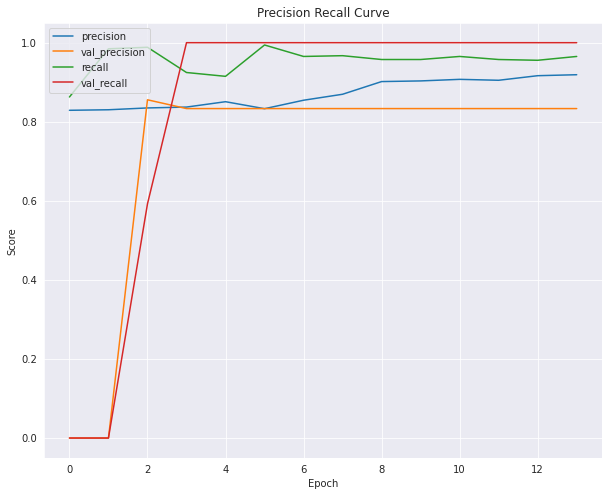

In [50]:
plt.figure(figsize=(10,8))
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Precision Recall Curve')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['precision', 'val_precision', 'recall', 'val_recall', 'f1_score', 'val_f1_score'], loc='upper left')
plt.show()

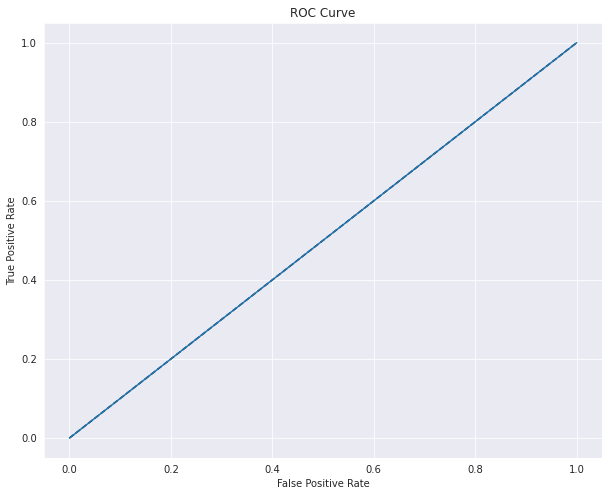

In [51]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob

y_pred_prob = (model.predict(x_test) > 0.5).astype("int32")

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Analysis after Model Training

ValueError: x and y must have same first dimension, but have shapes (12,) and (14,)

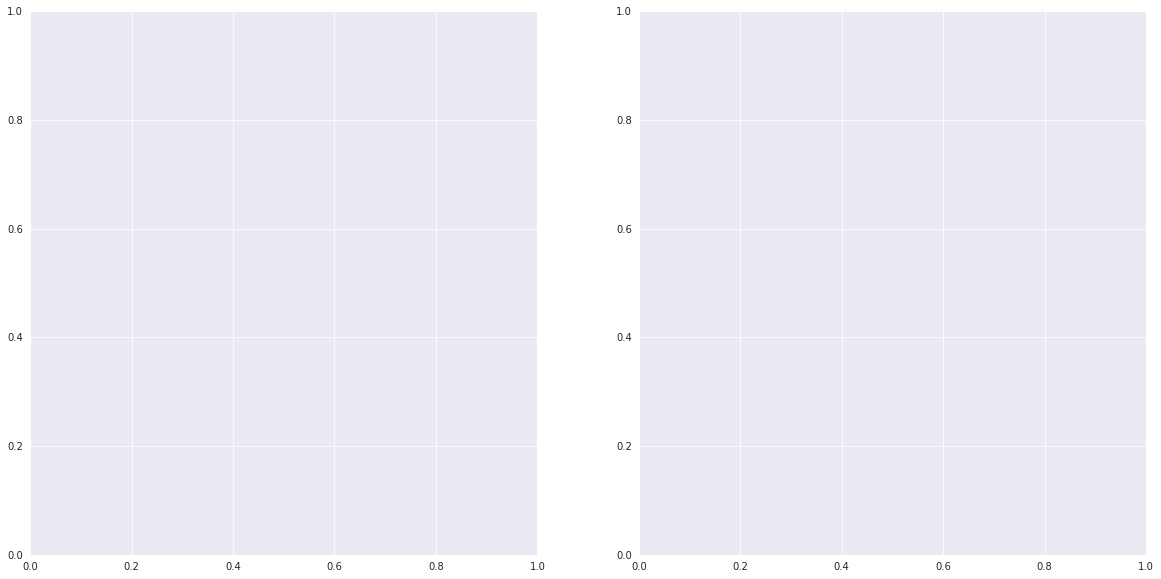

In [52]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [53]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [54]:
print(classification_report(y_test, predictions, target_names = ['Normal','Abnormal)']))

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        26
   Abnormal)       0.83      1.00      0.91       130

    accuracy                           0.83       156
   macro avg       0.42      0.50      0.45       156
weighted avg       0.69      0.83      0.76       156



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
cm = confusion_matrix(y_test,predictions)
cm

array([[  0,  26],
       [  0, 130]])

In [56]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

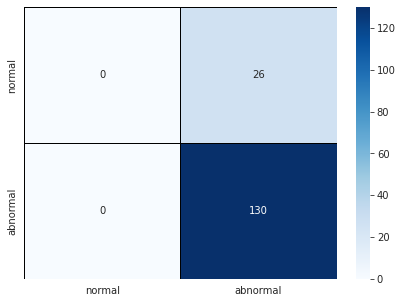

In [57]:
plt.figure(figsize = (7,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [41]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

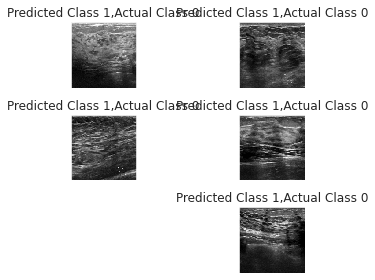

In [58]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

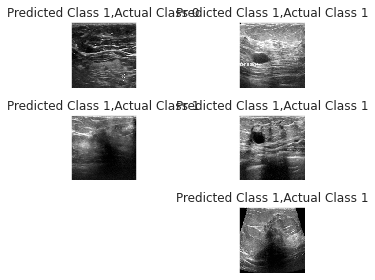

In [61]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1